In [1]:
import pandas as pd
import numpy as np
from khaiii import KhaiiiApi
import gensim
import pyLDAvis.gensim
import numpy as np
import logging
from gensim.models.coherencemodel import CoherenceModel
import matplotlib.pyplot as plt
import time
from pprint import pprint

In [2]:
data = pd.read_csv("./modi_data/kor_full.csv") ############
#data = data.drop(['Unnamed: 0'], axis=1)
data.head()

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


,no,year,kor_full
0,137,2002,"탐색 알고리즘 교육을 위한 S/W 컴포넌트의 개발 탐색알고리즘교육, 컴퓨터프로그래밍..."
1,147,2002,프로젝트 학습을 기반으로 하는 ICT 활용 수업 모형의 개발 및 적용 ICT 활용교...
2,148,2002,"분산 컴퓨팅 환경에서의 웹 교육 컴포넌트 개발과정 모델링 웹기반 교육, 컴포넌트 개..."
3,149,2002,효과적인 아동용 WBI를 위한 한글 타이포그래피의 가해성 분석과 활용 타이포 그래피...
4,150,2002,"교수 · 학습 디지털 컨텐트 통합메타데이터 및 개체-관계 모델 설계 교수.학습, 컨..."


In [3]:
data = pd.read_csv("./modi_data/kor_full.csv") ############
#data = data.drop(data.index[50:]) ###################### decrease size
#data = data.drop(['Unnamed: 0'], axis=1)
print(data)

       no  year                                           kor_full
0     137  2002  탐색 알고리즘 교육을 위한 S/W 컴포넌트의 개발 탐색알고리즘교육, 컴퓨터프로그래밍...
1     147  2002  프로젝트 학습을 기반으로 하는 ICT 활용 수업 모형의 개발 및 적용 ICT 활용교...
2     148  2002  분산 컴퓨팅 환경에서의 웹 교육 컴포넌트 개발과정 모델링 웹기반 교육, 컴포넌트 개...
3     149  2002  효과적인 아동용 WBI를 위한 한글 타이포그래피의 가해성 분석과 활용 타이포 그래피...
4     150  2002  교수 · 학습 디지털 컨텐트 통합메타데이터 및 개체-관계 모델 설계 교수.학습, 컨...
..    ...   ...                                                ...
807  1121  2020  R 매핑을 이용한 인공지능의 교육적 활용 탐색 - 국외 문헌 분석을 중심으로 - 인...
808  1122  2020  중학교 정보교과에서 짝 프로그래밍이 4Cs 향상에 미치는 영향 짝 프로그래밍, 4C...
809  1123  2020  자동 분류 기술을 활용한 온라인 강의 평가 방법 빅 데이터 분석, 온라인 강의 평가...
810  1124  2020  인공지능교육 역량 강화를 위한 교원 연수 프로그램과 교사 요구분석 인공지능교육, 교...
811  1125  2020  초·중등 현직 교원의 스크래치 활용 교수자료 개발에 대한 경험 분석 : ASSURE...

[812 rows x 3 columns]
/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in 

In [4]:
dfWordList = pd.read_excel("./khaiii_word_cor.xlsx")
dfWordList2 = pd.read_excel("./khaiii_word_cor_etc.xlsx")
#print(dfWordList2)

dfWordDel = dfWordList[dfWordList["수정"] == "삭제"]
dfWordMod = dfWordList[dfWordList["수정"] != "삭제"]
dfWordDiv = dfWordList2
#print(dfWordMod)

seriesDelete = dfWordDel["기존"]
stopword = []
for word in seriesDelete.values:
    stopword.append(word)
#print(stopword)

seriesModify = dfWordMod["기존"]
modiword = []
for word in seriesModify.values:
    modiword.append(word)
#print(len(modiword))

seriesModify2 = dfWordMod["수정"]
modiword2 = []
for word in seriesModify2.values:
    modiword2.append(word)
#print(len(modiword2))

seriesDivide = dfWordDiv["기존"]
divword = []
for word in seriesDivide.values:
    divword.append(word)
#print(divword)
#print(len(divword))

seriesDivide2 = dfWordDiv["수정"]
divword2 = []
for words in seriesDivide2.values:
    divword2.append(words.split(', '))
#print(divword2)
#print(len(divword2))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [5]:
api = KhaiiiApi()
def khaiiiTokenizer(raw, stopword=stopword, pos=['NNG', 'NNP', 'NNB', 'NP', 'NR', 'SL']): # 일반명사 고유명사 의존명사 대명사 수사 외국어
    list = []
    
    for word in api.analyze(raw): #raw data
        #print(word)
        
        for morph in word.morphs:
            #print(morph.lex)
            if len(morph.lex) > 1 and morph.tag in pos and morph.lex not in stopword: 
                if morph.tag == 'SL':
                    morph.lex = morph.lex.lower()
                if morph.lex in divword:
                    morph.lex = divword2[divword.index(morph.lex)]
                    list.extend(morph.lex)
                elif morph.lex in modiword:
                    morph.lex = modiword2[modiword.index(morph.lex)]
                    list.append(morph.lex)
                else: list.append(morph.lex)
                
    return list

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [6]:
tokenized = data["kor_full"].apply(lambda row: khaiiiTokenizer(row))
#print(tokenized)
tokenized.to_excel("./final_data/1210token_khaiii_full.xls") ##############
print("========= tokenization completed =========")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
========= tokenization completed =========


In [7]:
#lda
id2word = gensim.corpora.Dictionary(tokenized)

wordlist = []
for i in range(len(id2word)):
    #print(id2word[i])
    wordlist.append(id2word[i])
#print(wordlist)
seriesWordlist = pd.Series(wordlist)
seriesWordlist.to_excel("./final_data/1210wordlist_khaiii_full.xls") #################

corpus=[id2word.doc2bow(text) for text in tokenized]
#print("id2word for each document : ", corpus)
print("# words in total : ", len(id2word))
print("# documents : ", len(corpus))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
# words in total :  4217
# documents :  812


In [8]:
def compute_coherence_values(dictionary, corpus, texts, limit, start=2, step=1):
    """
    Compute c_v coherence for various number of topics

    Parameters:
    ----------
    dictionary : Gensim dictionary
    corpus : Gensim corpus
    texts : List of input texts
    limit : Max num of topics

    Returns:
    -------
    model_list : List of LDA topic models
    coherence_values : Coherence values corresponding to the LDA model with respective number of topics
    """
    perplexity_values = []
    coherence_values = []
    model_list = []
    for num_topics in range(start, limit, step):
        print(num_topics)
        model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=num_topics,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
        model_list.append(model)
        perplexitymodel = model.log_perplexity(corpus)
        perplexity_values.append(perplexitymodel)
        coherencemodel = CoherenceModel(model=model,
                                        texts=texts,
                                        dictionary=dictionary,
                                        coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
    return model_list, perplexity_values, coherence_values

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [9]:
#start = time.time()
model_list, perplexity_values, coherence_values = compute_coherence_values(dictionary=id2word,
                                                        corpus=corpus,
                                                        texts=tokenized,
                                                        start=2,
                                                        limit=31, #####
                                                        step=1)
#print("time : ", ( time.time() - start )/60, "min")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30


/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


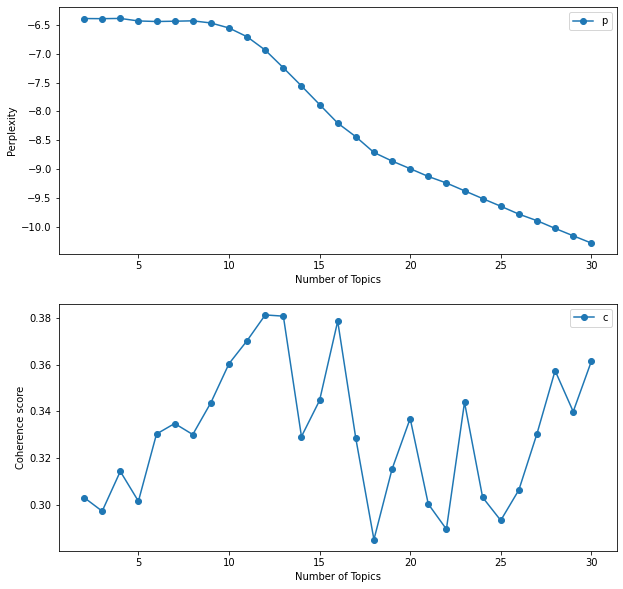

In [10]:
limit=31 ######
start=2
step=1
x = range(start, limit, step)


fig, ax = plt.subplots(2,1, figsize=(10, 10))

ax[0].plot(x, perplexity_values, marker='o')
ax[0].set_xlabel("Number of Topics")
ax[0].set_ylabel("Perplexity")
ax[0].legend(("perplexity"), loc='best')

ax[1].plot(x, coherence_values, marker='o')
ax[1].set_xlabel("Number of Topics")
ax[1].set_ylabel("Coherence score")
ax[1].legend(("coherence_values"), loc='best')
plt.show()

In [11]:
for m, pv in zip(x, perplexity_values):
  print("Num Topics =", m, " has Perplexity Value of", round(pv, 4))

for m, cv in zip(x, coherence_values):
  print("Num Topics =", m, " has Coherence Value of", round(cv, 4))

Num Topics = 2  has Perplexity Value of -6.3938
Num Topics = 3  has Perplexity Value of -6.396
Num Topics = 4  has Perplexity Value of -6.3919
Num Topics = 5  has Perplexity Value of -6.4355
Num Topics = 6  has Perplexity Value of -6.4449
Num Topics = 7  has Perplexity Value of -6.4401
Num Topics = 8  has Perplexity Value of -6.4333
Num Topics = 9  has Perplexity Value of -6.4704
Num Topics = 10  has Perplexity Value of -6.557
Num Topics = 11  has Perplexity Value of -6.709
Num Topics = 12  has Perplexity Value of -6.9397
Num Topics = 13  has Perplexity Value of -7.2453
Num Topics = 14  has Perplexity Value of -7.5593
Num Topics = 15  has Perplexity Value of -7.8809
Num Topics = 16  has Perplexity Value of -8.2018
Num Topics = 17  has Perplexity Value of -8.4374
Num Topics = 18  has Perplexity Value of -8.7098
Num Topics = 19  has Perplexity Value of -8.858
Num Topics = 20  has Perplexity Value of -8.9901
Num Topics = 21  has Perplexity Value of -9.1246
Num Topics = 22  has Perplexity 

In [12]:
a = int(input("set the number of topics "))
optimal_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                                id2word=id2word,
                                                num_topics=a,
                                                random_state=100,
                                                update_every=1,
                                                iterations=1000,
                                                chunksize=100,
                                                passes=10,
                                                alpha='auto',
                                                eta='auto',
                                                per_word_topics=True)
model_topics = optimal_model.show_topics(formatted=False)
pprint(optimal_model.print_topics(num_words=30))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
[(0,
  '0.301*"sw" + 0.038*"교육" + 0.035*"모델" + 0.033*"윤리" + 0.027*"학부모" + '
  '0.026*"정보" + 0.023*"정책" + 0.021*"소속" + 0.013*"개발" + 0.013*"통신" + '
  '0.012*"소프트웨어교육" + 0.011*"관련" + 0.011*"세부" + 0.011*"담당" + 0.010*"자녀" + '
  '0.010*"대두" + 0.009*"교육청" + 0.008*"환경" + 0.008*"포함" + 0.008*"차기" + '
  '0.008*"글로벌" + 0.008*"연계" + 0.007*"보호" + 0.007*"대국민" + 0.007*"소프트웨어" + '
  '0.007*"포럼" + 0.007*"스스로" + 0.007*"초등" + 0.007*"공청회" + 0.007*"유관"'),
 (1,
  '0.195*"온라인" + 0.126*"민원" + 0.078*"몰입" + 0.034*"비교" + 0.025*"국내외" + '
  '0.024*"그룹" + 0.023*"예측" + 0.022*"지역" + 0.016*"학생" + 0.015*"초점" + 0.014*"증강" '
  '+ 0.013*"사이버" + 0.013*"패턴" +

In [13]:
title = input("set the title of html file ")
vis = pyLDAvis.gensim.prepare(optimal_model, corpus, id2word)
pyLDAvis.save_html(vis, title+".html")

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [14]:
# topic proportion

proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    proportion.append(row)
print(pd.DataFrame(proportion))

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)
                    0                 1                 2                 3  \
0     (2, 0.21553157)    (5, 0.3151984)   (7, 0.41266254)  (11, 0.03299175)   
1      (2, 0.3057192)  (5, 0.037377562)  (7, 0.100475915)   (11, 0.5387456)   
2     (2, 0.21880527)   (7, 0.13581628)  (8, 0.014987723)   (9, 0.60236084)   
3     (2, 0.12554735)   (7, 0.14209701)   (9, 0.49780867)  (11, 0.22488447)   
4     (2, 0.10046191)   (5, 0.25508302)   (7, 0.10844378)   (9, 0.39702338)   
..                ...               ...               ...               ...   
807   (2, 0.48346934)   (4, 0.32776806)  (6, 0.016185544)  (7, 0.035824563

In [22]:
proportion = []
for i, row_list in enumerate(optimal_model[corpus]):
    #print("document number : ", i)
    row = row_list[0]
    #print(row)
    inner_proportion = ["-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-", "-"] # numtopics 12
    for j, (topic_num, prop) in enumerate(row):
        for k in range(12): # numtopics 12
            if topic_num == k:
                inner_proportion[k] = prop
    proportion.append(inner_proportion)
    #print(inner_proportion)
#print(proportion)

#topic_proportions = pd.DataFrame(data["title"])

/Users/uni613/Library/Python/3.8/lib/python/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [23]:
topic_proportions = pd.concat([data["no"], pd.DataFrame(proportion)], axis=1)
topic_proportions.columns = ["Title", "T0", "T1", "T2", "T3", "T4", "T5", "T6", "T7", "T8", "T9", "T10", "T11"] #num topics = 12
print(topic_proportions)
topic_proportions.to_excel("./final_data/1210_topic_proportions_total.xlsx")

     Title         T0         T1        T2         T3         T4         T5  \
0      137          -          -  0.215544          -          -   0.315169   
1      147          -          -  0.305720          -          -  0.0373771   
2      148          -          -  0.218796          -          -          -   
3      149          -          -  0.125546          -          -          -   
4      150          -          -  0.100383          -          -   0.255099   
..     ...        ...        ...       ...        ...        ...        ...   
807   1121          -          -  0.483488          -   0.327768          -   
808   1122          -          -  0.040467          -          -          -   
809   1123          -  0.0949009  0.094128  0.0121725  0.0163519          -   
810   1124  0.0319225          -  0.401873          -   0.166078          -   
811   1125          -          -  0.249153          -          -  0.0856778   

            T6        T7         T8         T9 T10 

ModuleNotFoundError: No module named 'openpyxl'